In [ ]:
# This file aims to display some functions regarding Brightway 2.5, to demonstrate what can be done with the software when you have a foreground model matched with ecoinvent's bio- and technosphere.

# Analysis

### 1. Loading the project

In [ ]:
# basic imports from brightway
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
from bw2io.importers import SingleOutputEcospold2Importer
import bw2analyzer as bwa
from bw2data import methods

# other relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [ ]:
# define a project where we install the databases and work in this script
bd.projects.set_current('brightway25')

### 2. Database overview

In [ ]:
bd.databases

In [ ]:
bd.projects.current

In [ ]:
ei_clca = bd.Database('ecoinvent310clca')
ei_bio = bd.Database('ecoinvent-3.10-biosphere')
db_template = bd.Database('bw25_db')
el_bio3 = bd.Database('biosphere3')

### 3. Database exploration

In [ ]:
db_template.search('ceramics')

In [ ]:
ei_clca.search('ceramics')

In [ ]:
# define a process as object in the project
ceramics_bw = db_template.get(name = 'porcelain ceramics production', location = "RER", unit = 'kilogram')
ceramics_ei = ei_clca.get(name = 'sanitary ceramics production', location = "CH", unit = 'kilogram')


In [ ]:
# quickly print all exchanges of the process defined above, sorted by amount (large to small)
exchanges = sorted(ceramics_bw.exchanges(), key=lambda exc: exc['amount'], reverse=True)
for exc in exchanges:
    print(exc)

### 4. Impact assessment methods

In [ ]:
# here we will analyse the set of methods that are available as part of the background
list(bd.methods)[:5]

In [ ]:
# printing all methods that contain a specific keyword, e.g. "climate change"
climate_methods = [m for m in bd.methods if any("climate change" in str(part).lower() for part in m)]
for method in climate_methods:
    print(method)

In [ ]:
# selecting the impact assessment methods that we want to use in our analysis
lcia_gwp100 = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')
lcia_water = ('EF v3.1','water use','user deprivation potential (deprivation-weighted water consumption)')
lcia_land = ('EF v3.1', 'land use', 'soil quality index')

### 5. LCI 

In [ ]:
# export the LCI to excel in an overview format
bi.export.excel.write_lci_excel(db_template.name,
                                objs=[ceramics_bw],
                                dirpath=Path.cwd())

### 6. LCIA

In [ ]:
# Quick LCIA calculation
ceramics_bw_lca = ceramics_bw.lca(lcia_gwp100)
ceramics_bw_lca.score


In [ ]:
ceramics_ei_lca = ceramics_ei.lca(lcia_gwp100)
ceramics_ei_lca.score

### 7. Contribution analysis

In [ ]:
# One option to do a contribution analysis is to use the recursive calculation method
bwa.print_recursive_calculation(ceramics_bw,
lcia_method=lcia_gwp100,max_level=3,cutoff=0.05)

In [ ]:
# Another option is to use the recursive calculation to an object, which returns a DataFrame
ceramics_bw_ca = bwa.utils.recursive_calculation_to_object(ceramics_bw,
                                          lcia_method=lcia_gwp100,
                                          max_level=1,
                                          cutoff=0.02,
                                          as_dataframe=True,
                                          )
ceramics_bw_ca

In [ ]:
# The goal here is to conduct the same analysis for the ecoinvent process so we can compare the contributions later
ceramics_ei_ca = bwa.utils.recursive_calculation_to_object(ceramics_ei,
                                          lcia_method=lcia_gwp100,
                                          max_level=1,
                                          cutoff=0.02,
                                          as_dataframe=True,
                                          )
ceramics_ei_ca

In [ ]:
# Elementary flows contribution analysis by process
ceramics_ei_lca.to_dataframe().pivot_table(index=['col_name', 'row_name'], values='amount', aggfunc='sum').sort_values(by='amount', ascending=False)

In [ ]:
# Elementary flows contribution analysis as summary table
ceramics_ei_lca.to_dataframe().pivot_table(index='row_name',values='amount',aggfunc='sum')

### 8. Plot Contribution analysis graphs

In [ ]:
# Filter out the parent processes that are not relevant for the contribution analysis
ceramics_bw_ca = ceramics_bw_ca.dropna(subset='parent') 
ceramics_ei_ca = ceramics_ei_ca.dropna(subset='parent')



In [ ]:
# First, we plot the contribution analysis for the brigthway ceramics production process
f, ax = plt.subplots(figsize=(6, 3))
sns.barplot(y='name', x='score', data=ceramics_bw_ca, ax=ax)
ax.set(
    title='Contribution analysis of the product under study',
    xlabel='CO2 eq. emissions (kg)',
    ylabel='')
plt.tight_layout()
plt.show()


In [ ]:
# Then, we plot the same for the ecoinvent ceramics production process
f, ax = plt.subplots(figsize=(6, 3))
sns.barplot(y='name', x='score', data=ceramics_ei_ca, ax=ax)
ax.set(
    title='Contribution analysis of the product under study',
    xlabel='CO2 eq. emissions (kg)',
    ylabel='')
plt.tight_layout()
plt.show()


### 9. Comparison

In [42]:
combined_df = pd.concat([ceramics_bw_ca.set_index('name').score,ceramics_ei_ca.set_index('name').score],
                        keys=['ceramics_bw','ceramics_ei'],
                        names=['activity','contributor'])
combined_df

activity     contributor                                         
ceramics_bw  market for kaolin                                       0.145070
             market for feldspar                                     0.015081
             market group for electricity, high voltage              0.240714
             market group for natural gas, high pressure             0.282982
             packaging glass factory construction                    0.031445
ceramics_ei  ceramic factory construction                            0.096369
             market for electricity, medium voltage                  0.188177
             market for heat, district or industrial, natural gas    2.730413
             market for kaolin                                       0.111534
Name: score, dtype: float64

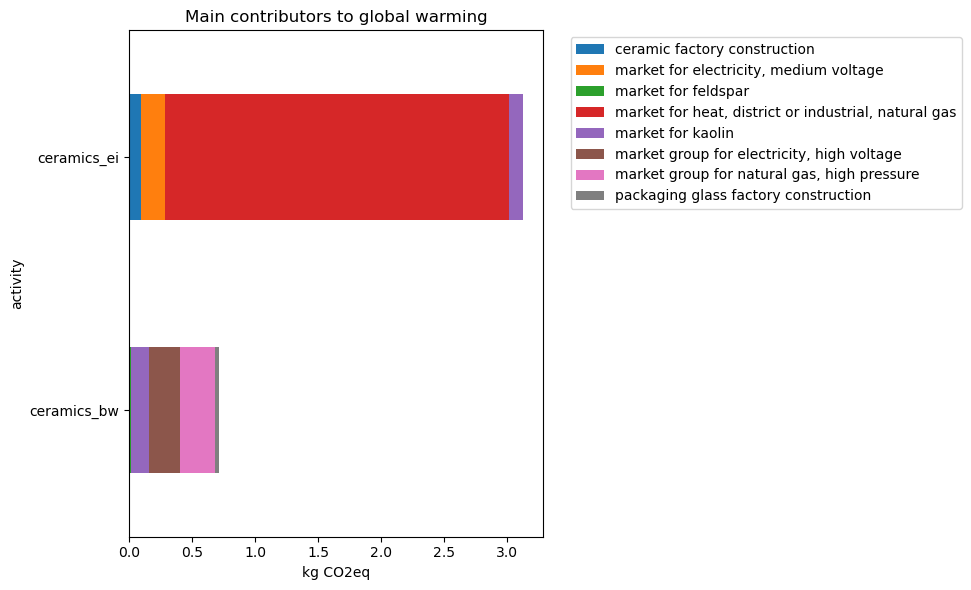

In [45]:
ax = combined_df.unstack().plot.barh(
    stacked=True,
    title='Main contributors to global warming',
    xlabel='kg CO2eq',
    figsize=(10,6)
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # moves legend outside
plt.tight_layout()
plt.show()